<a href="https://colab.research.google.com/github/PMatthaei/pymarl-results/blob/master/visualize_pymarl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Usage:**

1.   Each pymarl run returns an info.json holding logged metrics.
2.   Each folder represents a experiment and is therefore named after agent and environment(seperated via "_"). 
3.   Running the following f.e. visualizes all combinations of *envs* and *algos* if they exist in the file system aka. in the repository. The following experiments should be plotted: 3m_qmix, 3m_coma, 8m_qmix, 8m_coma 
```
extract_plot_data(algos=['qmix', 'coma'], envs=['3m', '8m'])
```



In [1]:
!git clone https://github.com/PMatthaei/pymarl-results.git

Cloning into 'pymarl-results'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (566/566), done.
remote: Compressing objects: 100% (487/487), done.
remote: Total 566 (delta 129), reused 452 (delta 64), pack-reused 0
Receiving objects: 100% (566/566), 29.70 MiB | 24.99 MiB/s, done.
Resolving deltas: 100% (129/129), done.


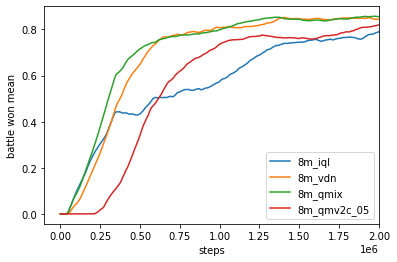

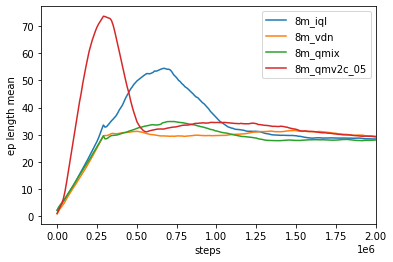

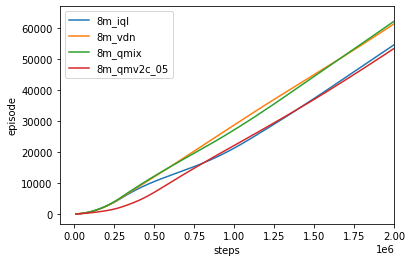

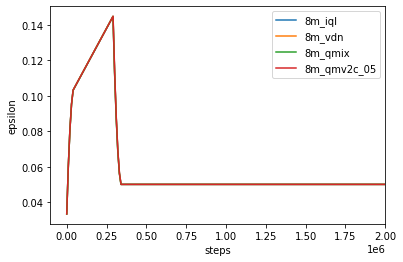

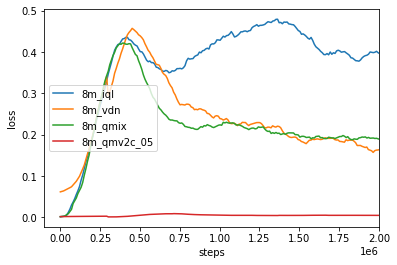

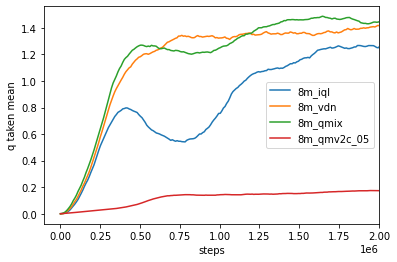

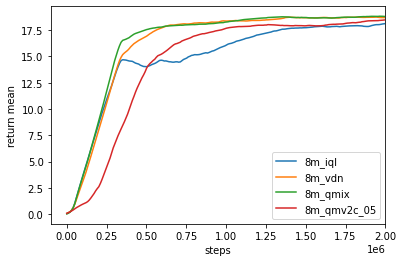

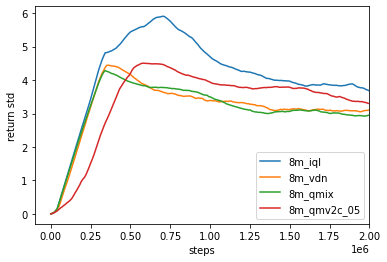

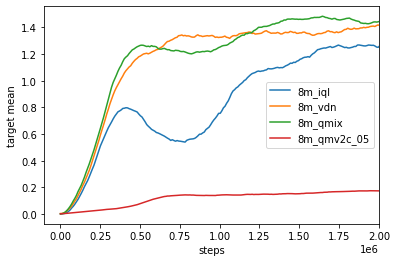

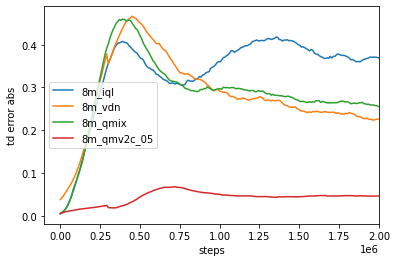

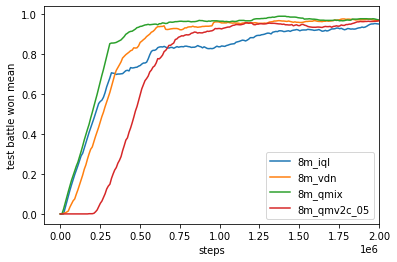

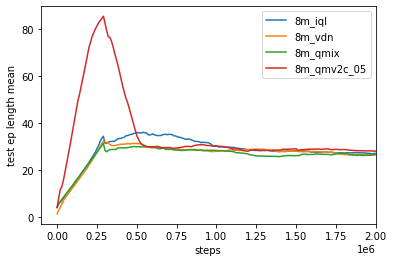

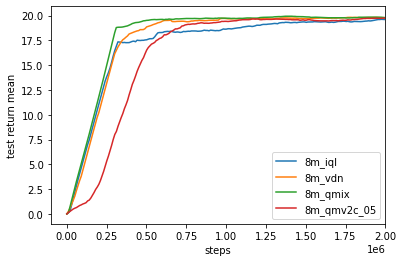

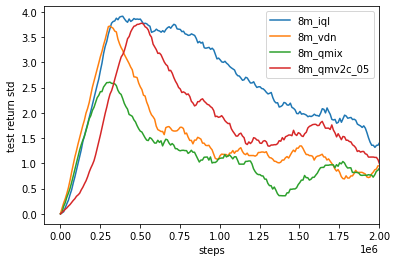

<Figure size 432x288 with 0 Axes>

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import re

from scipy.signal import lfilter
from pathlib import Path

plot_data = {}
metrics = []

def extract_plot_data(algos=[], envs=[]):
  for path in Path('/content/pymarl-results').rglob('*info*.json'):
    label = extract_label(path, algos+envs)

    if is_algo(path, algos) and is_env(path, envs):
      with open(path) as json_file:
          data = json.load(json_file)
          for metric in data:
            if '_T' not in metric:

              if metric not in metrics:
                metrics.append(metric)

              transposed_identifier = metric+'_T'
              xs = data[transposed_identifier]
              ys = data[metric]

              if metric in plot_data:
                plot_data[metric].append((xs, ys, label))
              else:
                plot_data[metric] = []
                plot_data[metric].append((xs, ys, label))

n = 30  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1

def plot():
  for metric in metrics:
    if metric == 'grad_norm':
      continue
    for i, data in enumerate(plot_data[metric]):

      plt.plot(data[0], lfilter(b,a,data[1]), label=data[2])
      plt.xlabel('steps')
      metric_label = metric.replace('_', ' ')
      plt.xlim(right=2000000)
      plt.ylabel(metric_label)
    plt.legend(loc='best')
    plt.show()
    plt.savefig(metric+'.png')

def is_env(path, envs):
  if len(envs) == 0:
    return True

  return any(env in str(path) for env in envs)

def is_algo(path, algos):
  if len(algos) == 0:
    return True

  return any(algo in str(path) for algo in algos)

def extract_label(path, search):
  return re.search(".*(results/)(.*)(/source).*",str(path))[2]


extract_plot_data(algos=['qmix', 'qmv2', 'iql', 'vdn'], envs=['8m'])
plot()